In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
import math
torch.manual_seed(1234)

#from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import psutil
import sys
from itertools import islice
from collections import defaultdict
import string
import unicodedata
from multiprocess import Pool
import pickle
import random 
random.seed(1234)

# use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device

'cuda'

#### A simple/minimal implementation of the BERT model (https://arxiv.org/pdf/1810.04805v2.pdf) 

##### The transformer block and multihead attention layer implementations are based on the Andrej Karpathy GPT youtube tutorial. In this case, we use a transformer encoder block which uses bi-directional context, differing from the transformer decoder in GPT which is unidirectional (achieved via causal masking of attention weights).

#### Pre-Training:

##### We will train our BERT model on the masked language modeling (MLM) task. The MLM task involves masking out parts of the input sequence and having the model reconstruct those missing parts. By pre-training the model on this task using a large corpus, it learns a strong representation of language (e.g. it learns syntax structure, gains knowledge about the world and different entities, word semantics and sentiment) which can then be trasferred into many different downstream language tasks with some additional finetuning. The learning process is made even more robust by masking out randomly selected tokens from the input sequence which don't necessarily have to be in a contiguous chunk.


In [2]:
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, block_size, embedding_dim, total_head_size, num_heads, dropout_rate):
        super().__init__()

        assert total_head_size % num_heads == 0, "head_size needs to be integer multiple of num_heads"

        self.block_size = block_size
        self.embedding_dim = embedding_dim
        self.total_head_size = total_head_size 
        self.head_size = total_head_size // num_heads 
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        # define parameters
        self.key = nn.Linear(embedding_dim, self.total_head_size, bias=False)
        self.query = nn.Linear(embedding_dim, self.total_head_size, bias=False)
        self.value = nn.Linear(embedding_dim, self.total_head_size, bias=False)
        self.attn_dropout = nn.Dropout(dropout_rate)

        # we also need to apply a linear projection to make the output residual the same dimension as the input
        self.proj = nn.Linear(total_head_size, embedding_dim) 
        self.output_dropout = nn.Dropout(dropout_rate)


    # define forward pass, input shape: (B,T,C) where B=batch size, T=block_size, C=embedding_dim
    # the attn_mask is a mask that can be used for masking out the attention weights for padding tokens 
    def forward(self, x, attn_mask):
        B, T, C = x.shape
        #print(f"B = {B}, T={T}, C={C}")
        k = self.key(x) # (B,T,H) where H is the total_head_size
        q = self.query(x) # (B,T,H)
        v = self.value(x) # (B,T,H)

        # reshape (B,T,H) --> (B,T,n,h), where n=num_heads and h=head_size and H=n*h
        k = k.view(B,T,self.num_heads,self.head_size) 
        q = q.view(B,T,self.num_heads,self.head_size) 
        v = v.view(B,T,self.num_heads,self.head_size) 

        # now we transpose so that the num_heads is the second dimension followed by T,h
        # this allows us to batch matrix mutliply for all heads simulataneously to compute their attention weights
        # (B,T,n,h) --> (B,n,T,h) 
        k = k.transpose(1,2) 
        q = q.transpose(1,2)
        v = v.transpose(1,2)

        # compute attention scores manually (slower)
        W = q @ k.transpose(-2,-1)  / math.sqrt(self.head_size) # (B,n,T,T)
        attn_mask = attn_mask.view(B,1,1,T)        
        #print(f"W shape= {W.shape}, attn_mask shape = {attn_mask.shape}")
        W = W.masked_fill(attn_mask == 0, float('-inf')) 
        W = F.softmax(W, dim=-1)
        # apply dropout to attention weights
        W = self.attn_dropout(W)
        out = W @ v # (B,n,T,h)
        

        # use pytorch built-in function for faster computation of attention scores (set the 'is_causal' parameter for applying causal masking)
        #out = F.scaled_dot_product_attention(q,k,v,attn_mask=attn_mask.bool(),dropout_p=self.dropout_rate if self.training else 0,is_causal=False)

        # we can transpose the output from (B,n,T,h) --> (B,T,n,h)
        # since the last two dimensions of the transposed tensor are non-contiguous, we apply 
        # contiguous() which return a contiguous tensor
        out = out.transpose(1,2).contiguous()

        # finally we collapse the last two dimensions to get the concatenated output, (B,T,n,h) --> (B,T,n*h) 
        out = out.view(B,T,self.total_head_size)

        # now we project the concatenated output so that it has the same dimensions as the multihead attention layer input
        # (we need to add it with the input because of the residual connection, so need to be same size) 
        out = self.proj(out) # (B,T,C) 

        # apply dropout
        out = self.output_dropout(out)

        return out
    

# a simple mlp 
class FeedForward(nn.Module):
    def __init__(self, embedding_dim, dropout_rate):
        super().__init__()
        # we add extra computations by growing out the feed-forward hidden size by a factor of 4
        # we also add an extra linear layer at the end to project the residual back to same dimensions as input
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4*embedding_dim),  
            nn.ReLU(),
            nn.Linear(4*embedding_dim, embedding_dim), 
            nn.Dropout(dropout_rate)
        )
    
    # in the forward pass, concatenate the outputs from all the attention heads
    def forward(self, x):
        return self.net(x)
    

# transformer encoder block with residual connection and layer norm
# Note: the original transformer uses post layer norms, here we use pre layer norms, i.e. layer norm is applied at the input
# instead of the output, this typically leads to better results in terms of training convergence speed and gradient scaling 
class TransformerBlock(nn.Module):
    def __init__(self, block_size, embedding_dim, head_size, num_heads, dropout_rate):
        super().__init__()
        self.sa = MultiHeadAttention(block_size, embedding_dim, head_size, num_heads, dropout_rate) # multi-head attention layer 
        self.ff = FeedForward(embedding_dim, dropout_rate)   # feed-forward layer
        self.ln1 = nn.LayerNorm(embedding_dim) # layer norm at input of multi-head attention
        self.ln2 = nn.LayerNorm(embedding_dim) # layer norm at input of feed-forward

    # in the forward pass, concatenate the outputs from all the attention heads
    def forward(self, x, attn_mask):
        # residual connection between input and multi-head attention output (also note that we're doing a pre-layer norm, i.e. layer norm at the input of the multi-head attention)
        x = x + self.sa(self.ln1(x), attn_mask)
        # residual connection between multi-head attention output and feed-forward output (also note that we're doing a pre-layer norm, i.e. layer norm at the input of the feed-forward)
        x = x + self.ff(self.ln2(x)) 
        return x
    

# BERT model with multiple transformer blocks 
class BERTModel(nn.Module):
    def __init__(self, vocab_size, block_size, embedding_dim, head_size, num_heads, num_blocks, pad_token_id, dropout_rate=0.2):
        super().__init__()

        self.vocab_size = vocab_size
        self.block_size = block_size        # block_size is just the input sequence length
        self.embedding_dim = embedding_dim
        self.head_size = head_size
        self.hum_heads = num_heads
        self.num_blocks = num_blocks

        '''
        Define model parameters
        '''
        # token embedding layer 
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_token_id) # shape: (vocab_size,C)
        # position embedding layer
        self.pos_embedding = nn.Embedding(block_size, embedding_dim) # shape: (T,C)
        # segment embedding layer (disabled for now)
        #self.segment_embedding = nn.Embedding(2, embedding_dim)

        # stack of transformer blocks
        self.blocks = nn.ModuleList([TransformerBlock(block_size, embedding_dim, head_size, num_heads, dropout_rate) for _ in range(num_blocks)])

        # pooling transformation of CLS token (for downstream tasks requiring full sentence hidden representation)
        #self.pooling_linear = nn.Linear(embedding_dim, embedding_dim) # shape: (C,C)
        #self.pooling_activation_fn = nn.Tanh()

        # output layer
        self.ln = nn.LayerNorm(embedding_dim)
        self.output_linear = nn.Linear(embedding_dim, vocab_size)
        self.dropout = torch.nn.Dropout(dropout_rate)

        # store position indices inside a buffer for fast access when computing position embeddings
        position_idx = torch.arange(block_size, device=device).unsqueeze(0)
        self.register_buffer('position_idx', position_idx)


        # forward pass takes in a batch of input token sequences idx of shape (B,T) and corresponding targets of shape (B,T)
    def forward(self, idx, attn_mask, segment_idx=None):
        B, T = idx.shape
        # get token embeddings
        token_embeds = self.token_embedding(idx) # (B,T,C)
        # add positional encoding
        pos_embeds = self.pos_embedding(self.position_idx[:,:T]) # (T,C) 
        
        # add sentence segment embedding (disabled for now)
        # segment_embeds = self.segment_embedding(segment_idx) # segment_idx is an integer tensor of shape (B,T) and has 0's at positions corresponding to 
        
        # the first sentence and 1's at positions corresponding to the second sentence 
        x = token_embeds + pos_embeds # (B,T,C)
        # pass through transformer blocks to get encoding
        for block in self.blocks:
            x = block(x, attn_mask) # (B,T,C)
    
        # get CLS token encoding and apply pooling transform
        #cls_encoding = x[:,0] # (B,C)
        #pooled_cls_encoding = self.pooling_activation_fn(self.pooling_linear(cls_encoding)) # (B,C)

        # apply final layers norm
        x = self.ln(x)

        # compute output logits
        logits = self.output_linear(self.dropout(x))

        return logits 


#### Load dataset

Simple Wikipedia Dataset (contains multiple languages..)

In [ ]:
'''
# Load the simple English Wikipedia dataset
wiki_dataset = load_dataset("wikipedia", "20220301.simple")
train_dataset = wiki_dataset['train']
documents = train_dataset[:]['text']


# split each document into list of sentences, aggregate all sentences inside a single list
def extract_sentences(document):
    return document.replace('\n\n', '\n').split('\n')

with Pool() as pool:
    all_sentences = []
    for result in tqdm(pool.imap(extract_sentences, documents), total=len(documents)):
        all_sentences.append(result)
text = [sentence for document_sentences in all_sentences for sentence in document_sentences]

print(f"Total number of sentences: {len(text)}")
'''

#### BookCorpus Dataset. For simplicity, we will only use the first 2M sentences from the dataset.

In [27]:
"""
# load the books corpus dataset from file
dataset = Dataset.from_file('book_corpus_dataset/archive/train/dataset.arrow')

print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

# check how many sentences are in the dataset
print(len(dataset))

# show some sentences from the dataset
print(dataset[:10]['text'])
"""

"""
# get chunk of 10M sentences
chunk = dataset[:10000000]['text']

# size in Mb
sys.getsizeof(chunk)/1024**2

# save it to a txt file
with open('bookcorpus_small.txt', 'w') as output:
    for sent in chunk:
        output.write(f"{sent}\n")
"""


def read_first_n_lines(n):
    with open("bookcorpus_small.txt", 'r') as file:
        return list(islice(file, n))
    
# read in 2000000 sentences from the txt file
text = read_first_n_lines(8000000)
text = [line.strip() for line in text]
print(f"Number of sentences in reduced corpus: {len(text)}")


Number of sentences in reduced corpus: 8000000


In [2]:
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 1229.03 MB


#### Do a bit of preprocessing remove sections that are not relevant for language modeling, such as isbn numbers, URLs, etc


In [29]:
text_clean = []
for s in text:
    if "http" in s or "isbn" in s or "@" in s or "^" in s or "#" in s or "~" in s or ">" in s or "<" in s or "{" in s or "}" in s or "all rights reserved" in s:
        continue
    else:
        text_clean.append(s)


In [30]:
print(len(text_clean))
text = text_clean

7993754


#### WordPiece Tokenizer Algorithm Implementation (https://huggingface.co/learn/nlp-course/chapter6/6?fw=pt)

In [7]:
# pretokenize the corpus into words and get unigram counts, we will only use the first sentence as an example
word_freqs = defaultdict(int)
for s in text:
    words = s.split()
    for word in words:
        word_freqs[word] += 1
    break    

In [8]:
word_freqs

defaultdict(int,
            {'the': 2,
             'half-ling': 1,
             'book': 1,
             'one': 1,
             'in': 1,
             'fall': 1,
             'of': 1,
             'igneeria': 1,
             'series': 1,
             'kaylee': 2,
             'soderburg': 2,
             'copyright': 1,
             '2013': 1,
             'all': 1,
             'rights': 1,
             'reserved': 1,
             '.': 1})

First, we initialize the WordPiece vocabulary. This contains all the unique first letters of every word in the corpus and all other letters that appear in words prefixed by '##'

In [45]:
# initialize WordPiece vocabulary
vocab = []
for word in word_freqs.keys():
    if word[0] not in vocab:
        vocab.append(word[0])
    for letter in word[1:]:
        prefixed = '##' + letter
        if prefixed not in vocab:
            vocab.append(prefixed)

# now add the special tokens
vocab = vocab + ["[PAD]", "[CLS]", "[UNK]", "[MASK]", "[SEP]"]

vocab = sorted(vocab)         
print(vocab) 

['##-', '##0', '##1', '##3', '##a', '##b', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##y', '.', '2', '[CLS]', '[MASK]', '[PAD]', '[SEP]', '[UNK]', 'a', 'b', 'c', 'f', 'h', 'i', 'k', 'o', 'r', 's', 't']


Next, we split every unique word in corpus into characters and prefix the characters which are not the first with '##'\
e.g. 'word' --> 'w', '##o', '##r', '##d'

In [22]:
splits = {word: [c if i==0 else f"##{c}" for i,c in enumerate(word)] for word in word_freqs.keys()}
splits

{'the': ['t', '##h', '##e'],
 'half-ling': ['h', '##a', '##l', '##f', '##-', '##l', '##i', '##n', '##g'],
 'book': ['b', '##o', '##o', '##k'],
 'one': ['o', '##n', '##e'],
 'in': ['i', '##n'],
 'fall': ['f', '##a', '##l', '##l'],
 'of': ['o', '##f'],
 'igneeria': ['i', '##g', '##n', '##e', '##e', '##r', '##i', '##a'],
 'series': ['s', '##e', '##r', '##i', '##e', '##s'],
 'kaylee': ['k', '##a', '##y', '##l', '##e', '##e'],
 'soderburg': ['s', '##o', '##d', '##e', '##r', '##b', '##u', '##r', '##g'],
 'copyright': ['c', '##o', '##p', '##y', '##r', '##i', '##g', '##h', '##t'],
 '2013': ['2', '##0', '##1', '##3'],
 'all': ['a', '##l', '##l'],
 'rights': ['r', '##i', '##g', '##h', '##t', '##s'],
 'reserved': ['r', '##e', '##s', '##e', '##r', '##v', '##e', '##d'],
 '.': ['.']}

Now, we will iteratively merge pairs of these splits into subword tokens. To select which pair to merge, we compute a score for all observed pairs as follows:

$score(c1,c2) = \frac{freq(c1,c2)}{freq(c1) * freq(c2)}$

where c1 and c2 are a pair of splits, freq(c1,c2) is the count of how many times c1,c2 co-occur in the corpus and freq(c) is the count of how many times we observe c. This merger algorithm trherefore prioritizes merging splits which appear together frequently but appear separately more rarely.


For example, 

freq('t', '##h') = 2 (observed in the word 'the':2) and 

freq('t') = 2 (observed in the word 'the':2)

freq('##h') = 4 (observed in words 'the':2, 'copyright':1,'rights':1)  

score('t', '##h') = 1/4

In [35]:
# function for computing pair scores
def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)

    for word,freq in word_freqs.items():            
        split = splits[word]
        # if word only contains one split
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        
        # count up every individual split and adjacent pair of splits 
        for i in range(len(split)-1):
            pair = (split[i], split[i+1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {pair: freq/(letter_freqs[pair[0]]*letter_freqs[pair[1]]) for pair,freq in pair_freqs.items()}
    return scores

In [40]:
pair_scores = compute_pair_scores(splits)
print(pair_scores)

# get pair with largest score (ties broken by picking first occurance of largest value)
max_score_pair = max(pair_scores, key = lambda x: pair_scores[x])
print("Pair with largest score: ", max_score_pair)

{('t', '##h'): 0.25, ('##h', '##e'): 0.03125, ('h', '##a'): 0.2, ('##a', '##l'): 0.05, ('##l', '##f'): 0.0625, ('##f', '##-'): 0.5, ('##-', '##l'): 0.125, ('##l', '##i'): 0.025, ('##i', '##n'): 0.05, ('##n', '##g'): 0.041666666666666664, ('b', '##o'): 0.2, ('##o', '##o'): 0.04, ('##o', '##k'): 0.2, ('o', '##n'): 0.125, ('##n', '##e'): 0.03125, ('i', '##n'): 0.125, ('f', '##a'): 0.2, ('##l', '##l'): 0.03125, ('o', '##f'): 0.25, ('i', '##g'): 0.08333333333333333, ('##g', '##n'): 0.041666666666666664, ('##e', '##e'): 0.01171875, ('##e', '##r'): 0.0390625, ('##r', '##i'): 0.075, ('##i', '##a'): 0.04, ('s', '##e'): 0.020833333333333332, ('##i', '##e'): 0.0125, ('##e', '##s'): 0.041666666666666664, ('k', '##a'): 0.2, ('##a', '##y'): 0.13333333333333333, ('##y', '##l'): 0.08333333333333333, ('##l', '##e'): 0.015625, ('s', '##o'): 0.13333333333333333, ('##o', '##d'): 0.13333333333333333, ('##d', '##e'): 0.041666666666666664, ('##r', '##b'): 0.125, ('##b', '##u'): 0.5, ('##u', '##r'): 0.125, ('

Now we merge these two splits into a new subword token and add the subword to our vocabulary.

In [46]:
subword = max_score_pair[0] + max_score_pair[1].lstrip('#')
vocab.append(subword)
print(vocab)

['##-', '##0', '##1', '##3', '##a', '##b', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##y', '.', '2', '[CLS]', '[MASK]', '[PAD]', '[SEP]', '[UNK]', 'a', 'b', 'c', 'f', 'h', 'i', 'k', 'o', 'r', 's', 't', '20']


In [49]:
def merge_pair(c1, c2, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) > 1:
            i = 0
            while i < len(split)-1:
                if split[i] == c1 and split[i+1] == c2:
                    merged = c1 + c2.lstrip('#')
                    split = split[:i] + [merged] + split[i+2:]
                else:
                    i += 1
                splits[word] = split

    return splits                    

In [51]:
splits = merge_pair(max_score_pair[0], max_score_pair[1], splits)
splits

{'the': ['t', '##h', '##e'],
 'half-ling': ['h', '##a', '##l', '##f', '##-', '##l', '##i', '##n', '##g'],
 'book': ['b', '##o', '##o', '##k'],
 'one': ['o', '##n', '##e'],
 'in': ['i', '##n'],
 'fall': ['f', '##a', '##l', '##l'],
 'of': ['o', '##f'],
 'igneeria': ['i', '##g', '##n', '##e', '##e', '##r', '##i', '##a'],
 'series': ['s', '##e', '##r', '##i', '##e', '##s'],
 'kaylee': ['k', '##a', '##y', '##l', '##e', '##e'],
 'soderburg': ['s', '##o', '##d', '##e', '##r', '##b', '##u', '##r', '##g'],
 'copyright': ['c', '##o', '##p', '##y', '##r', '##i', '##g', '##h', '##t'],
 '2013': ['20', '##1', '##3'],
 'all': ['a', '##l', '##l'],
 'rights': ['r', '##i', '##g', '##h', '##t', '##s'],
 'reserved': ['r', '##e', '##s', '##e', '##r', '##v', '##e', '##d'],
 '.': ['.']}

We can keep merging iteratively until we have reahed some maximum vocab size

In [55]:
max_vocab_size = 50

while len(vocab) < max_vocab_size:
    # compute all pair scores
    pair_scores = compute_pair_scores(splits)
    # get pair with largest score (ties broken by picking first occurance of largest value)
    max_score_pair = max(pair_scores, key = lambda x: pair_scores[x])
    # add new subword to vacabulary
    subword = max_score_pair[0] + max_score_pair[1].lstrip('#')
    vocab.append(subword)
    # update splits 
    splits = merge_pair(*max_score_pair, splits)


In [58]:
print(vocab)

['##-', '##0', '##1', '##3', '##a', '##b', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##y', '.', '2', '[CLS]', '[MASK]', '[PAD]', '[SEP]', '[UNK]', 'a', 'b', 'c', 'f', 'h', 'i', 'k', 'o', 'r', 's', 't', '20', '201', '2013', '##f-', 'of', '##bu', '##py', 'th', '##ht']


Finally, we tokenize a given word into the learned subwords. To tokenize a word, we find the longest matching subword starting from the first character and we split the word. Then we repeat the process from the second half. If we reach the fiunal character and haven't found a matching subword from the vocabulary, then we declare the entire word as '[UNK]' 

In [61]:
def tokenize_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)    
        # find longest mactching subword subword
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            # no match found
            return ["[UNK]"]
        # found longest subword
        tokens.append(word[:i])
        word = word[i:]
        # add prefix
        if len(word) > 0:
            word = f"##{word}"
    return tokens            

In [62]:
tokenize_word("fabulous")

['f', '##a', '##bu', '##l', '##o', '##u', '##s']

#### All together, the WordPiece vocab generator can be implemented as follows.

In [4]:
class WordPieceTokenizer():
    def __init__(self):
        self.vocab = []
        self.word2int = {}
        self.int2word = {}
        # special tokens
        self.pad_token = "[PAD]"
        self.mask_token = "[MASK]"
        self.unk_token = "[UNK]"
        self.cls_token = "[CLS]"
        self.sep_token = "[SEP]"
        
        self.invalid_chars = ('*', '~', '_', '^', '`', '+', '\\', '[', ']', '<', '>')
        self.max_vocab_size = None
        

    def mask_token_id(self):
        return self.word2int[self.mask_token]

    def pad_token_id(self):
        return self.word2int[self.pad_token]

    def cls_token_id(self):
        return self.word2int[self.cls_token]

    def unk_token_id(self):
        return self.word2int[self.unk_token]

    def sep_token_id(self):
        return self.word2int[self.sep_token]

    def vocab_size(self):
        return len(self.vocab)
    
    def clean_sentence(self, s):
        # removes all control characters and invalid characters, replaces multiple adjacent whitespace with single whitespace
    
        #s = "".join(ch for ch in s if unicodedata.category(ch)[0] != 'C' and ch not in self.invalid_chars) 
        #s = " ".join(s.split())
        
        # remove all non-letter characters
        s = "".join(ch for ch in s if unicodedata.category(ch)[0]=='L' or unicodedata.category(ch)=='Zs') 
        s = " ".join(s.split())
        return s

    # generates wordpiece vocabulary of subwords from a given corpus
    # the input corpus is a list of sentences
    def generate_vocab(self, corpus, max_vocab_size):
        self.max_vocab_size = max_vocab_size
        # pretokenize the corpus into words and get unigram counts, we will only use the first sentence as an example
        word_freqs = defaultdict(int)
        for s in corpus:
            s = self.clean_sentence(s)
            words = s.split()
            for word in words:
                word_freqs[word] += 1
        
        # initialize WordPiece vocabulary
        for word in word_freqs.keys():
            if word[0] not in self.vocab:
                self.vocab.append(word[0])
            for letter in word[1:]:
                prefixed = '##' + letter
                if prefixed not in self.vocab:
                    self.vocab.append(prefixed)

        # now add special tokens
        self.vocab = self.vocab + [self.pad_token, self.cls_token, self.unk_token, self.mask_token, self.sep_token]

        # generate splits
        splits = {word: [c if i==0 else f"##{c}" for i,c in enumerate(word)] for word in word_freqs.keys()}
        
        # function for computing pair scores
        def compute_pair_scores(splits):
            letter_freqs = defaultdict(int)
            pair_freqs = defaultdict(int)

            for word,freq in word_freqs.items():            
                split = splits[word]
                # if word only contains one split
                if len(split) == 1:
                    letter_freqs[split[0]] += freq
                    continue
                
                # count up every individual split and adjacent pair of splits 
                for i in range(len(split)-1):
                    pair = (split[i], split[i+1])
                    letter_freqs[split[i]] += freq
                    pair_freqs[pair] += freq
                letter_freqs[split[-1]] += freq

            scores = {pair: freq/(letter_freqs[pair[0]]*letter_freqs[pair[1]]) for pair,freq in pair_freqs.items()}
            return scores
        
        # function for merging a pair of splits    
        def merge_pair(c1, c2, splits):
            for word in word_freqs:
                split = splits[word]
                if len(split) > 1:
                    i = 0
                    while i < len(split)-1:
                        if split[i] == c1 and split[i+1] == c2:
                            merged = c1 + c2.lstrip('#')
                            split = split[:i] + [merged] + split[i+2:]
                        else:
                            i += 1
                        splits[word] = split

            return splits    
        
        # generate the subword vocabulary
        pbar = tqdm(total=max_vocab_size, desc="Building vocab. Current vocab_size --> ")
        pbar.update(len(self.vocab))

        while len(self.vocab) < max_vocab_size:
            # compute all pair scores
            pair_scores = compute_pair_scores(splits)
            # get pairs with largest score 
            max_score = max(pair_scores.values())
            max_score_pairs = [pair for pair, score in pair_scores.items() if score== max_score]
            # randomly break ties
            max_score_pair = random.choice(max_score_pairs)
            # add new subword to vacabulary
            subword = max_score_pair[0] + max_score_pair[1].lstrip('#')
            self.vocab.append(subword)
            # update splits 
            splits = merge_pair(*max_score_pair, splits)
            pbar.update(1)
            
        self.vocab = sorted(set(self.vocab))
        self.word2int = {word:i for i,word in enumerate(self.vocab)}
        self.int2word = {i:word for i,word in enumerate(self.vocab)}


    def encode_sentence(self, s):
        # first clean the sentence
        s = self.clean_sentence(s)
        # tokenize the sentence into subword sequence
        subword_tokens = self.tokenize_sentence(s)
        # convert to token indices
        indices = [self.word2int[t] for t in subword_tokens]
        return indices

    # encode sentence into subword token indices
    def encode(self, sentences):
        encoded_sentences = []
        with Pool() as pool:
            # Note: since we're using map instead of imap, order of encoded sequences will differ from order of original sequences
            for result in tqdm(pool.map(self.encode_sentence, sentences), total=len(sentences), desc="Encoding sequences."):
                encoded_sentences.append(result)
        return encoded_sentences


    def decode_indices(self, indices):
        # first cnvert indices to subword tokens
        subwords = [self.int2word[ix] for ix in indices]
        # merge subwords
        i = 0
        while i < len(subwords)-1:
            a = subwords[i]
            b = subwords[i+1]
            if len(b) == 1:
                i += 1  
                continue
            if b[:2]=="##":
                subwords = subwords[:i] + [a+b.lstrip('#')] + subwords[i+2:]
            else:       
                i += 1    
        s = " ".join(subwords)
        return s


    # decode subword token index sequences back to sentences
    def decode(self, idx):
        sentences = []
        with Pool() as pool:
            for result in tqdm(pool.imap(self.decode_indices, idx), total=len(idx), desc="Decoding sequences."):
                sentences.append(result)    
        return sentences


    def tokenize_sentence(self, sent):
        tokens = []
        # split the sentence into words 
        # make sure to convert all characters to lower case because our vocabulary does not contain
        # upper case letters
        words = sent.lower().split()
        # tokenize each word
        for word in words:
            tokens = tokens + self.tokenize_word(word)
        return tokens

    def tokenize_word(self, word):
        tokens = []
        while len(word) > 0:
            i = len(word)    
            # find longest mactching subword subword
            while i > 0 and word[:i] not in self.vocab:
                i -= 1
            if i == 0:
                # no match found
                return [self.unk_token]
            # found longest subword
            tokens.append(word[:i])
            word = word[i:]
            # add prefix
            if len(word) > 0:
                word = f"##{word}"
        return tokens          


In [10]:
# instantiate tokenizer object
tokenizer = WordPieceTokenizer()

In [34]:
# generate vocabulary (this is the slowest part because the subword splits are merger iteratively)
tokenizer.generate_vocab(text, max_vocab_size=8192)
print(tokenizer.vocab)

Building vocab. Current vocab_size --> : 100%|██████████| 8192/8192 [1:32:49<00:00,  1.47it/s]

['##a', '##aaaaaaaaaaaaagggggggggggghhhhhhhhhhhh', '##aaaaaaaaaaaagggggggggggghhhhhhhhhhhh', '##aaaaaaaaaaagggggggggggghhhhhhhhhhhh', '##aaaaaaaaaagggggggggggghhhhhhhhhhhh', '##aaaaaaaaagggggggggggghhhhhhhhhhhh', '##aaaaaaaagggggggggggghhhhhhhhhhhh', '##aaaaaaaauughh', '##aaaaaaagggggggggggghhhhhhhhhhhh', '##aaaaaaarrrrrrrgggghhhhhhhh', '##aaaaaaauughh', '##aaaaaagggggggggggghhhhhhhhhhhh', '##aaaaaarrrrrrrggggggggggghhh', '##aaaaaarrrrrrrgggghhhhhhhh', '##aaaaaauughh', '##aaaaagggggggggggghhhhhhhhhhhh', '##aaaaaggggggghhhhhhhhh', '##aaaaagggggghhhhhh', '##aaaaarrrrggggggggghhhhhh', '##aaaaarrrrggggghhhhhhh', '##aaaaarrrrgggghhhhh', '##aaaaarrrrrrrggggggggggghhh', '##aaaaarrrrrrrgggghhhhhhhh', '##aaaaauughh', '##aaaagggggggggggghhhhhhhhhhhh', '##aaaaggggggghhhhhhhhh', '##aaaagggggghhhhhh', '##aaaaggghhh', '##aaaagghh', '##aaaagongongonaarggg', '##aaaarrrggghhhhhhh', '##aaaarrrrggggggggghhhhhh', '##aaaarrrrgggggghhhhhhhhh', '##aaaarrrrggggghhhhhhh', '##aaaarrrrgggghhhhh', '##aaaarrrrrggg

In [13]:
# test encoding and decoding a sentence
s = text[0]
print(s)
print(tokenizer.tokenize_sentence(s))
encoded = tokenizer.encode([s])
print(encoded)
decoded = tokenizer.decode(encoded)
print(decoded)

NameError: name 'text' is not defined

Now, lets encode the dataset into integer token sequences.

In [73]:
dataset_encoded = tokenizer.encode(text)

Encoding sequences.: 100%|██████████| 7993754/7993754 [00:00<00:00, 10383100.01it/s]


In [7]:

# save a copy of the trained tokenizer to file
'''
with open('WordPiece_tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
'''

# load tokenizer object from file
'''
with open('WordPiece_tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file) 
'''

# save encoded dataset to file
'''
with open('dataset_encoded', 'wb') as file:
    pickle.dump(dataset_encoded, file)   
'''

'''
with open('dataset_encoded_1M', 'rb') as file:
    dataset_encoded = pickle.load(file)
'''  

In [8]:
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 3362.88 MB


Total num sequences: 1000000
Shortest: 0
Longest: 1896
Average: 46.170686


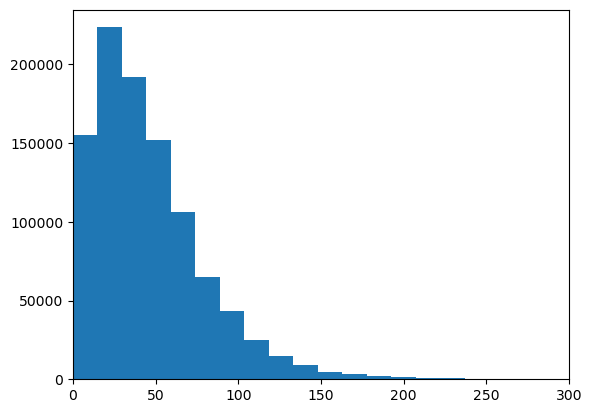

In [9]:
lengths = [len(s) for s in dataset_encoded] 
print(f"Total num sequences: {len(dataset_encoded)}")
print(f"Shortest: {min(lengths)}")
print(f"Longest: {max(lengths)}")
print(f"Average: {sum(lengths)/len(lengths)}")

import matplotlib.pyplot as plt

# show histrogram of sequence length distribution
plt.hist(lengths, bins=128)
plt.xlim(0,300)
plt.show()


#### PyTorch Dataset API for prepping data for Masked Language Model Task.

In [66]:
class BERTDataset(Dataset):
    def __init__(self, corpus, tokenizer, block_size, mlm_prob=0.15):
        self.corpus = corpus          # encoded sentences
        self.tokenizer = tokenizer    # wordpiece tokenizer
        self.block_size = block_size  # truncation/max length of sentences
        self.corpus_len = len(corpus) # size of corpus
        self.mlm_prob = mlm_prob
        self.vocab_size = tokenizer.vocab_size()

    def __len__(self):
        return self.corpus_len
    

    def __getitem__(self, idx):
        # get the sentence 
        s = self.get_corpus_sentence(idx)
        # truncate to block_size-1
        s = s[:self.block_size-1] 
        
        s_len = len(s)
        # replace tokens randomly
        s, label = self.replace_tokens(s)
        # append the CLS token at the beginning of sentence
        s = [self.tokenizer.cls_token_id()] + s
        # apply padding
        pad_len = max(0,self.block_size-s_len-1)
        s = s + [self.tokenizer.pad_token_id()]*pad_len
        label = [-100] + label + [-100]*pad_len
        # create attention mask which has 0's at positions of pad tokens and 1's everywhere else 
        attention_mask = [1]*(self.block_size-pad_len) + [0]*pad_len       

        # convert to torch tensors
        s = torch.tensor(s)
        label = torch.tensor(label)
        attention_mask = torch.tensor(attention_mask)

        # Note: Unlike the original BERT, we are not returning a pair of sentences, so we
        # don't need to return segment labels or next_sentence label 
        return {"masked_input" : s, "label" : label, "attention_mask" : attention_mask}


    # randomly replace tokens with mlm_prob probability
    def replace_tokens(self, s):

        # the labels for a masked token is the original token index and -100 for non-masked tokens
        label = [-100] * len(s)
        for i,t in enumerate(s):
            p = random.random()    
            if p < self.mlm_prob:
                p = p/self.mlm_prob
                # replace with masked token with 80% probability
                if p < 0.8:
                    s[i] = self.tokenizer.mask_token_id()        

                elif p < 0.9:
                    # replace with random token with 10% probability 
                    s[i] = random.randrange(self.vocab_size)
                
                # Note: for all three cases, i.e. token getting replaced by mask token, token getting replaced
                # by another random token or token not getting replaced, we want to predict the actual word as our target label 
                label[i] = t

        return s, label


    def get_corpus_sentence(self, idx):
        return self.corpus[idx]        
    

#### DataLoader for generating batches

In [60]:
block_size = 96
batch_size = 4

train_dataset = BERTDataset(dataset_encoded, tokenizer, block_size=block_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=1)  # set pin_memory for faster pre-fetching 
print(f"Total number of batches: {len(train_dataloader)}")

Total number of batches: 250000


In [61]:
# load an example batch and show the contents
sample_batch = next(iter(train_dataloader))
sample_batch

{'masked_input': tensor([[3475, 7277,  768, 3719, 2047, 2784, 2784, 6388,  768, 1846,  768,  657,
          7277,  768, 3476, 2047, 3350, 3480, 1846,  657, 3920,    0, 2390, 3476,
           769, 3126, 1458, 1458, 3362, 6519, 1133,  578,  768,  657, 3476, 6376,
           768, 6249, 7277,  768, 3933, 2047,  533, 2047, 1458,    0, 2938,  768,
          2784, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477,
          3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477,
          3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477,
          3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477, 3477],
         [3475, 7263,    0, 3476, 3476,  657, 3283, 3476, 1846, 2938,    0, 3476,
           768, 6249, 7277,  768, 5725,  768, 2390, 6908,  768,    0,  549, 6249,
          5220, 1133, 2784, 7851,  768, 3476, 2282, 2047, 3476, 5220,  768, 7851,
             0, 2784, 3526,  768, 7351, 5618,  768,  768, 2282, 3480, 2938, 2938,

In [22]:
print(sample_batch['masked_input'].shape)
print(sample_batch['label'].shape)
print(sample_batch['attention_mask'].shape)


torch.Size([32, 96])
torch.Size([32, 96])
torch.Size([32, 96])


#### Now let's train our BERT model on the MLM task. Note that were using fixed sized input sequences, denoted by block_size. Ideally we would want block_size to be as large as possible because a larger context window leads to the model learning better language representations from the MLM task. However, there are obvious computational constraints which prevent us from making block_size too big.

In [17]:
def save_model_checkpoint(model, optimizer, epoch=None, loss=None):
    # Save the model and optimizer state_dict
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    # Save the checkpoint to a file
    torch.save(checkpoint, 'BERT_checkpoint.pth')

In [18]:
embedding_dim = 384
head_size = embedding_dim
num_heads = 12
num_blocks = 8
dropout_rate = 0.2
max_iters = 3
learning_rate = 1e-4
smoothed_loss = 0.0

model = BERTModel(vocab_size=tokenizer.vocab_size(), block_size=block_size, embedding_dim=embedding_dim, head_size=head_size, num_heads=num_heads, num_blocks=num_blocks, pad_token_id=tokenizer.pad_token_id(), dropout_rate=dropout_rate)
# move model to device
m = model.to(device)

optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

num_params = sum(p.numel() for p in m.parameters())
print(f"Total number of parameters in transformer network: {num_params/1e6} M")
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

Total number of parameters in transformer network: 20.523776 M
RAM used: 5984.86 MB


In [23]:
# training loop
for epoch in range(max_iters):
    pbar = tqdm(train_dataloader, desc="Epochs")
    for batch in pbar:
        # sample a batch of trainin data
        xb, yb, attn_mask = batch['masked_input'], batch['label'], batch['attention_mask'] 
        # move batches to gpu
        xb = xb.to(device)
        yb = yb.to(device)
        attn_mask = attn_mask.to(device)

        # forward pass
        logits = m(xb, attn_mask)
        # compute loss
        B,T,vocab_size = logits.shape
        # reshape the logits and targets such that batch of input sequences are flattened into a single big input sequence
        # i.e. (B,T) --> (B*T)
        logits = logits.view(B*T,vocab_size) # reshaped to (B*T,vocab_size)
        yb = yb.view(B*T) # reshaped to (B*T)
        # compute cross entropy loss (i.e. average negative log likelihood)
        loss = F.cross_entropy(logits, yb, ignore_index=-100)

        # exponential moving average loss
        smoothed_loss = 0.9 * smoothed_loss + 0.1 * loss.item()

        # reset parameter gradients
        optimizer.zero_grad(set_to_none=True) 
        # backward pass
        loss.backward()
        # optimizer step
        optimizer.step()

        pbar.set_description(f"Epoch {epoch + 1}, Batch Loss: {loss:.3f}, Moving avg. Loss: {smoothed_loss:.3f}")   
    
    # save checkpoint 
    save_model_checkpoint(m, optimizer)    

Epoch 1, Batch Loss: 1.006, Moving avg. Loss: 1.178:  19%|█▉        | 12107/62452 [14:42<1:01:08, 13.72it/s]  


KeyboardInterrupt: 

In [ ]:
'''
# Load the checkpoint from the file
checkpoint = torch.load('BERT_checkpoint.pth')

# Initialize the model and optimizer
model = BERTModel(vocab_size=tokenizer.vocab_size(), block_size=block_size, embedding_dim=embedding_dim, head_size=head_size, num_heads=num_heads, num_blocks=num_blocks, pad_token_id=tokenizer.pad_token_id(), dropout_rate=dropout_rate)
# move model to device
m = model.to(device)

optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

# Load the model and optimizer state_dict from the checkpoint
m.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

m.train()

'''

#### Let's look at some test predictions made by our trained model

In [118]:
# first create test dataset (since first 1M lines are used for training, grab lines from after that point)
with open("bookcorpus_small.txt", 'r') as f:
    # get 2000 lines
    test_lines = list(islice(f, 2000000, 2002000))

In [116]:
# clean the sentences
for i, s in enumerate(test_lines):
    s = test_lines[i].strip()
    test_lines[i] = "".join(ch for ch in s if unicodedata.category(ch)[0]=='L' or unicodedata.category(ch)=='Zs') 